In [213]:
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from planet import planet

In [231]:
# Function to split real and imaginary part of complex data into individual element of an array
def split_complex_data(data):
    split_data = np.zeros([data.shape[0],2*data.shape[1]])
    for i in range(data.shape[1]):
        split_data[:,2*i] = data[:,i].real
        split_data[:,2*i+1] = data[:,i].imag
    return split_data

# Function to split testing data according the type of tissue
def split_t2_tissues(data):
    csf_test = [] # T2 = 1.99
    gm_test = []  # T2 = 0.1
    wm_test = [] # T2 = 0.08

    for i in range(len(data)):
        if gt_test[i] == 1.99:
            csf_test.append(data[i,:])

        if gt_test[i] == 0.1:
            gm_test.append(data[i,:])
        
        if gt_test[i] == 0.08:
            wm_test.append(data[i,:])

    csf_test = np.asarray(csf_test)
    gm_test  = np.asarray(gm_test)
    wm_test  = np.asarray(wm_test)
    return csf_test, gm_test, wm_test

# Function for Monte Carlo Simulation
def monte_carlo(data):
    pdf = [] #empty list to store probability value
    result = 0

    # Neural network
    if data.shape[1] == 12:
        predicted_t2 = model.predict(data)

    # PLANET
    if data.shape[1] == 6:
        TR, npcs, B0 = 3e-3, 6, 3 # TR = relaxation time, npcs = number of phase cycles, B0 =main magnetic field
        alpha = np.deg2rad(30) # alpha = flip angle
        pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
        predicted_t2 = planet(data, alpha, TR, 1, pcs=pcs, compute_df=False)
    
    for i in range(len(predicted_t2)):
        result = result + predicted_t2[i]
        pdf.append(result/(i+1)) #append result of each iteration to the empty list

    pdf  = np.asarray(pdf)
    return result/len(data), pdf

In [224]:
# Load voxel and ground truth t2 data
voxel_train = np.load('voxel_train.npy')
gt_train = np.load('gt_train.npy')

# Split training and test set, 1%
test_size = 100
voxel_test = voxel_train[-test_size:, :]
gt_test = gt_train[-test_size:,:]
voxel_train = voxel_train[:-test_size,:]
gt_train = gt_train[:-test_size,:]

print('Training data:', voxel_train[0,:])
print('Ground Truth T2:', gt_train[0,:])

Training data: [ 0.06421593+0.00327071j  0.11623111+0.06185092j  0.07089394+0.11925318j
 -0.00245724+0.13829132j -0.05461785+0.10650547j -0.05002071+0.03513936j]
Ground Truth T2: [0.1]


In [225]:
new_voxel_train = split_complex_data(voxel_train)
print('Complex voxel data split into real and imaginary parts:', new_voxel_train[0,:])
new_voxel_test = split_complex_data(voxel_test)

Complex voxel data split into real and imaginary parts: [ 0.06421593  0.00327071  0.11623111  0.06185092  0.07089394  0.11925318
 -0.00245724  0.13829132 -0.05461785  0.10650547 -0.05002071  0.03513936]


In [46]:
# Define the network structure
inputs = tf.keras.Input(shape=(12,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [47]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

history = model.fit(new_voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# 2nd set of parameters
# model.fit(voxel_train, gt_train,epochs=100, batch_size=100, validation_data=(voxel_valid,gt_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/10
891/891 [==============================] - 1s 978us/step - loss: 0.0014 - mse: 0.0014 - val_loss: 8.1538e-04 - val_mse: 8.1538e-04
Epoch 6/10
891/891 [==============================] - 1s 977us/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/10
891/891 [==============================] - 1s 970us/step - loss: 8.2784e-04 - mse: 8.2784e-04 - val_loss: 1.9235e-04 - val_mse: 1.9235e-04
Epoch 8/10
891/891 [==========================

In [7]:
model = tf.keras.models.load_model('voxel_regression')

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


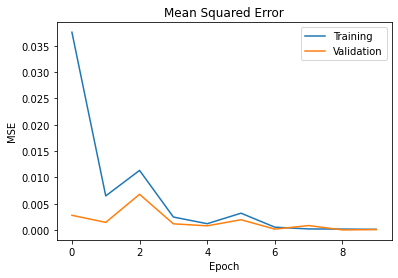

10/10 [==============================] - 0s 558us/step - loss: 1.2036e-04 - mse: 1.2036e-04
test loss, test mse: [0.00012036004773108289, 0.00012036004773108289]


In [219]:
#print(model.summary())
print(history.history.keys())

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

results = model.evaluate(new_voxel_test, gt_test, batch_size=10)
print("test loss, test mse:", results)

In [27]:
#model.save('voxel_regression')

INFO:tensorflow:Assets written to: voxel_regression\assets


In [229]:
csf_test, gm_test, wm_test = split_t2_tissues(voxel_test)
new_csf_test, new_gm_test, new_wm_test = split_t2_tissues(new_voxel_test)

In [232]:
# PLANET : Monte Carlo
mean_csf_t2_p, csf_pdf_p = monte_carlo(csf_test) 
mean_gm_t2_p, gm_pdf_p = monte_carlo(gm_test)
mean_wm_t2_p, wm_pdf_p = monte_carlo(wm_test)

# Neural network : Monte Carlo
mean_csf_t2, csf_pdf = monte_carlo(new_csf_test) 
mean_gm_t2, gm_pdf = monte_carlo(new_gm_test)
mean_wm_t2, wm_pdf = monte_carlo(new_wm_test)


bins = 5
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
fig.suptitle('Histograms of Predicted T2 using Neural Network')
sns.histplot(data=csf_pdf, bins=bins, stat='probability', kde=True, ax=ax1)
ax1.set_xlim((df["value"].min(), df["value"].max()))
ax1.set_title('Mean T2 (CSF):%.2f' %mean_csf_t2)
ax1.set_xlabel('Predicted T2')
ax1.set_ylabel('Probability')

sns.histplot(data=gm_pdf, bins=bins, stat='probability', kde=True, ax=ax2)
ax2.set_title('Mean T2 (GM):%.2f' %mean_gm_t2)
ax2.set_xlabel('Predicted T2')
ax2.set_ylabel('Probability')

sns.histplot(data=wm_pdf, bins=bins, stat='probability', kde=True, ax=ax3)
ax3.set_title('Mean T2 (WM):%.2f' %mean_wm_t2)
ax3.set_xlabel('Predicted T2')
ax3.set_ylabel('Probability')

AssertionError: 0 < a < 1 has been violated! a = 1.70115